In [54]:
using Base.Iterators: partition
using BSON
using Flux
using Flux: logitbinarycrossentropy, chunk
using Flux.Data: DataLoader
using Images
using Parameters: @with_kw
using Random
using CUDA
using JSON
using Plots

device = gpu

const n_patients   = 5366
const DS_PATH      = "../dataset_json/"

"../dataset_json/"

In [55]:
# return list of patients with their trajectories
function load_patients()
    patients = []
    for i = 1:n_patients
        p = JSON.parsefile(DS_PATH * "patient_" * string(i) * ".json")
        push!(patients, p) 
    end
    return patients
end

load_patients (generic function with 1 method)

In [56]:
ps = load_patients();

In [57]:
size(ps)

(5366,)

In [58]:
function feature_vector(p)
    S, MAP, mortality = p["trajectory"], p["MAP"], p["mortality"]
    return [convert(Array{Float32}, [S[i]; MAP[i] / 100.0; mortality]) for i=1:length(S)]
end

feature_vector (generic function with 1 method)

In [59]:

# load MNIST images and return loader
function get_data(batch_size, ps)
    p_m     = length(ps)
    m       = 0
    x_train = []
    for i=1:p_m
        pd = hcat(feature_vector(ps[i])...)
        push!(x_train, pd)
        m += size(pd)[2]
    end
    x_train = hcat(x_train...)
    y_train_dummy = [0.0 for i=1:m]
    println(size(x_train))
    println(size(y_train_dummy))
    DataLoader(x_train, y_train_dummy, batchsize = batch_size, shuffle = true)
end

get_data (generic function with 1 method)

In [60]:
loader = get_data(128, ps);

(51, 352328)
(352328,)


In [61]:
struct Encoder
    linear
    μ
    logσ
    Encoder(input_dim, latent_dim, hidden_dim, device) = new(
        Chain(
            Dense(input_dim, hidden_dim, Flux.relu), 
            Dense(hidden_dim, hidden_dim, Flux.relu),
            Dense(hidden_dim, hidden_dim, Flux.relu)) |> device,   # linear
        Dense(hidden_dim, latent_dim) |> device,        # μ
        Dense(hidden_dim, latent_dim) |> device,        # logσ
    )
end

In [62]:
function (encoder::Encoder)(x)
    h = encoder.linear(x)
    encoder.μ(h), encoder.logσ(h)
end

Decoder(input_dim, latent_dim, hidden_dim, device) = Chain(
    Dense(latent_dim, hidden_dim, Flux.relu),
    Dense(hidden_dim, hidden_dim, Flux.relu),
    Dense(hidden_dim, hidden_dim, Flux.relu),
    Dense(hidden_dim, input_dim)
) |> device


Decoder (generic function with 1 method)

In [63]:

function model_loss(encoder, decoder, λ, x, device)
    μ, logσ, decoder_z = reconstuct(encoder, decoder, x, device)
    len = size(x)[end]
    
    latent_loss     = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ)) / len
    generation_loss = sum(Flux.Losses.mse.(decoder_z, x)) / len
    reg             = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    return latent_loss + generation_loss + reg
end

model_loss (generic function with 1 method)

In [64]:
# arguments for the `train` function 
@with_kw mutable struct Args
    η = 1e-4                # learning rate
    λ = 0.001f0             # regularization paramater
    batch_size = 512        # batch size
    sample_size = 10        # sampling size for output    
    epochs = 20             # number of epochs
    seed = 0                # random seed
    cuda = true             # use GPU
    input_dim = 51          # image size
    latent_dim = 2          # latent dimension
    hidden_dim = 128        # hidden dimensions
    verbose_freq = 1000     # logging for every verbose_freq iterations
    tblogger = false        # log training with tensorboard
    save_path = "output"    # results path
end

Args

In [65]:
args = Args()

Args
  η: Float64 0.0001
  λ: Float32 0.001f0
  batch_size: Int64 512
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 51
  latent_dim: Int64 2
  hidden_dim: Int64 128
  verbose_freq: Int64 1000
  tblogger: Bool false
  save_path: String "output"


In [66]:
println("Initializing VAE model...")
encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim, device)
decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim, device)

# ADAM optimizer
opt = ADAM(args.η)
    
# parameters
ps = Flux.params(encoder.linear, encoder.μ, encoder.logσ, decoder)

Initializing VAE model...


Params([Float32[0.14682399 0.038977277 … -0.041228116 0.09528009; 0.102479495 -0.09052952 … -0.15316711 -0.05656607; … ; 0.1759439 0.12674668 … -0.07479827 -0.091564514; -0.025138497 0.048691083 … -0.17765024 0.1220722], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.04032908 -0.07610465 … 0.05850664 -0.0037732127; -0.04281975 0.024519477 … 0.07168713 0.015527641; … ; 0.13989864 0.111001 … 0.12477918 -0.07956367; -0.059360307 -0.13694574 … 0.11670715 -0.031292424], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.11667182 0.055403646 … -0.14978747 0.06037308; 0.07845563 0.100994565 … 0.13728091 0.13767903; … ; -0.07969397 -0.024841117 … 0.11429427 -0.021779804; 0.036788486 0.12232731 … 0.06181411 -0.010979784], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.10173344

In [67]:
!ispath(args.save_path) && mkpath(args.save_path)

false

In [68]:
function reconstuct(encoder, decoder, x, device)
    μ, logσ = encoder(x)
    z = μ + device(randn(Float32, size(logσ))) .* exp.(logσ)
    μ, logσ, decoder(z)
end

reconstuct (generic function with 1 method)

In [69]:
train_steps  = 0
train_losses = []
for epoch = 1:args.epochs
    println("\n\nEpoch $(epoch)")
    loss = 0.0

    for (x, _) in loader 
        loss, back = Flux.pullback(ps) do
            model_loss(encoder, decoder, args.λ, x |> device, device)
        end
        
        grad = back(1f0)
        Flux.Optimise.update!(opt, ps, grad)

        if train_steps % 50 == 1
            print(".")
            push!(train_losses, loss)
        end

        train_steps += 1
    end
    
    println("loss:", loss)
end



Epoch 1
........................................................loss:8.021355


Epoch 2
.......................................................loss:7.757317


Epoch 3
.......................................................loss:7.484852


Epoch 4
.......................................................loss:7.730127


Epoch 5
.......................................................loss:7.9947777


Epoch 6
.......................................................loss:7.4871163


Epoch 7
.......................................................loss:8.078402


Epoch 8
.......................................................loss:7.609451


Epoch 9
.......................................................loss:7.725587


Epoch 10
.......................................................loss:7.4640465


Epoch 11
.......................................................loss:7.5659246


Epoch 12
.......................................................loss:7.434907


Epoch 13
.................................

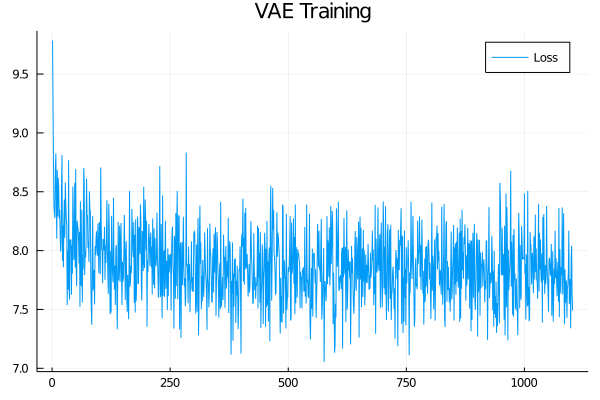

In [70]:
plot(1:length(train_losses), train_losses, title = "VAE Training", label = "Loss")

In [52]:
reconstuct(encoder, decoder, feature_vector(ps[1])[1] |> device, device)

(Float32[-0.9801049, -1.4210256], Float32[-1.7371886, -1.1873093], Float32[-0.008042442, 0.1343388, -0.16856849, -0.33470482, -0.2982672, -0.25210154, -0.24273482, -0.1659017, 0.038929664, 0.20856938  …  0.20645696, 0.20010307, -0.21434414, -0.21490487, -0.20877247, -0.38528815, -0.3881405, -0.3672067, 0.80070263, 0.13324888])

In [50]:
feature_vector(ps[1])[1]

51-element Array{Float32,1}:
 -0.35948172
  0.43990737
 -1.0590913
 -0.48791927
 -0.1743005
 -0.14888796
 -0.13654973
 -0.61029875
 -0.24194391
  0.28084475
  0.15390423
 -0.06261549
 -0.1839509
  ⋮
 -0.108395904
  0.28033373
  0.2831705
  0.2850545
  0.34823036
  0.34936163
  0.35055524
 -0.5739797
 -0.56734794
 -0.56106305
  0.83
  1.0